In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from tqdm import tqdm

In [2]:
import astropy.units as u
from astropy.cosmology import Planck18 as cosmos
import astropy.coordinates as coo
h = cosmos.H0.value/100

In [3]:
from Corrfunc.mocks import DDrppi_mocks, DDtheta_mocks
from Corrfunc.io import read_catalog
from Corrfunc.theory import DDrppi, DD
from my_util import convert_rp_pi_counts_to_wp, convert_3d_counts_to_cf

In [4]:
quasar = np.load('../catalogue/quasar_lss_all.npy')
# quasar = np.load('../catalogue/quasar_lss_nocp.npy')
random = np.load('../catalogue/random_quasar_lss_all.npy')
Nd = len(quasar)
Nr = len(random)

In [ ]:
quasar['z'].mean

In [5]:
dis_cov_q = cosmos.angular_diameter_distance(quasar['z']).to(u.Mpc).value*(1+quasar['z'])*h
dis_cov_r = cosmos.angular_diameter_distance(random['z']).to(u.Mpc).value*(1+random['z'])*h

In [6]:
Nbins = 15
rp_min = 3
rp_max = 100

sep = (np.log10(rp_max) - np.log10(rp_min)) / Nbins
rp_bin = 10**(np.arange(-10, Nbins+1)*sep + np.log10(rp_min))
r_p = (rp_bin[:-1]*rp_bin[1:])**0.5

Nbins = len(r_p)

# rp_bin = np.geomspace(rp_min, rp_max, Nbins+1)
# r_p = (rp_bin[:-1]*rp_bin[1:])**0.5

pimax = 100

pair counts

In [7]:
dd = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                   RA1=quasar['ra'], DEC1=quasar['dec'], CZ1=dis_cov_q, weights1=quasar['w'], is_comoving_dist=True, weight_type='pair_product')
rr = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                   RA1=random['ra'], DEC1=random['dec'], CZ1=dis_cov_r, weights1=random['w'], is_comoving_dist=True, weight_type='pair_product')
dr = DDrppi_mocks(
    autocorr=False, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin, 
    RA1=quasar['ra'], DEC1=quasar['dec'], CZ1=dis_cov_q, weights1=quasar['w'], 
    RA2=random['ra'], DEC2=random['dec'], CZ2=dis_cov_r, weights2=random['w'], 
    is_comoving_dist=True, weight_type='pair_product')

result of $\xi(r_p, \pi)$

In [9]:
result = convert_3d_counts_to_cf(Nd, Nd, Nr, Nr, dd, dr, dr, rr)

Text(0, 0.5, '$\\log r_p$')

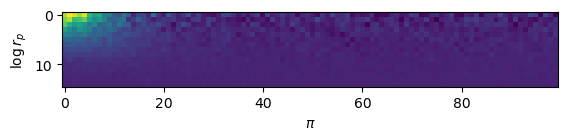

In [19]:
plt.imshow(result.reshape((Nbins, pimax)))
plt.xlabel('$\\pi$')
plt.ylabel('$\\log r_p$')

result of $w(r_p)$

In [10]:
w = convert_rp_pi_counts_to_wp(Nd, Nd, Nr, Nr, dd, dr, dr, rr, pimax=pimax, nrpbins=Nbins)

In [13]:
def get_wp(file):
    quasar = np.load(file)
    Nd = len(quasar)
    dis_cov_q = cosmos.angular_diameter_distance(quasar['z']).to(u.Mpc).value*(1+quasar['z'])*h
    dd = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                    RA1=quasar['ra'], DEC1=quasar['dec'], CZ1=dis_cov_q, weights1=quasar['w'], is_comoving_dist=True, weight_type='pair_product')
    dr = DDrppi_mocks(
        autocorr=False, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin, 
        RA1=quasar['ra'], DEC1=quasar['dec'], CZ1=dis_cov_q, weights1=quasar['w'], 
        RA2=random['ra'], DEC2=random['dec'], CZ2=dis_cov_r, weights2=random['w'], 
        is_comoving_dist=True, weight_type='pair_product')
    return convert_rp_pi_counts_to_wp(Nd, Nd, Nr, Nr, dd, dr, dr, rr, pimax=pimax, nrpbins=Nbins)

def get_wp2(quasar, random):
    Nd = len(quasar)
    Nr = len(random)
    dis_cov_q = cosmos.angular_diameter_distance(quasar['z']).to(u.Mpc).value*(1+quasar['z'])*h
    dis_cov_r = cosmos.angular_diameter_distance(random['z']).to(u.Mpc).value*(1+random['z'])*h
    dd = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                    RA1=quasar['ra'], DEC1=quasar['dec'], CZ1=dis_cov_q, weights1=quasar['w'], is_comoving_dist=True, weight_type='pair_product')
    dr = DDrppi_mocks(
        autocorr=False, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin, 
        RA1=quasar['ra'], DEC1=quasar['dec'], CZ1=dis_cov_q, weights1=quasar['w'], 
        RA2=random['ra'], DEC2=random['dec'], CZ2=dis_cov_r, weights2=random['w'], 
        is_comoving_dist=True, weight_type='pair_product')
    rr = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                   RA1=random['ra'], DEC1=random['dec'], CZ1=dis_cov_r, weights1=random['w'], is_comoving_dist=True, weight_type='pair_product')
    return convert_rp_pi_counts_to_wp(Nd, Nd, Nr, Nr, dd, dr, dr, rr, pimax=pimax, nrpbins=Nbins)

In [16]:
wh = get_wp('../catalogue/quasar_lss_high_L.npy')
wl = get_wp('../catalogue/quasar_lss_low_L.npy')
wp_origin = get_wp('../catalogue/quasar_lss_all.npy')

In [24]:
wzbin = []
for i in range(3):
    q = np.load(f'../catalogue/quasar_lss_z{i+1}.npy')
    r = random.copy()
    r['z'] = np.random.choice(q['z'], len(r))
    wzbin.append(get_wp2(q, r))

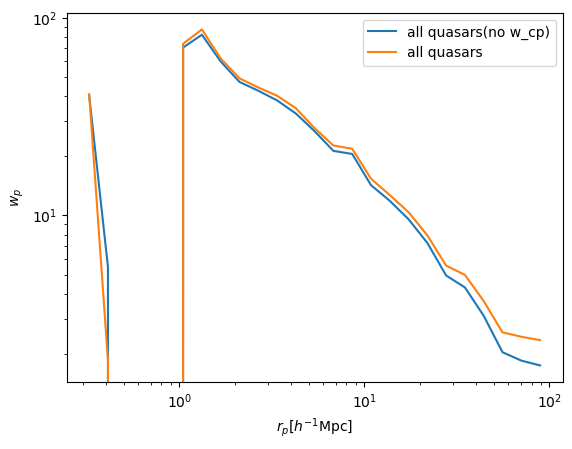

In [18]:
plt.plot(r_p, w, label='all quasars(no w_cp)')
plt.plot(r_p, wp_origin, label='all quasars')
# plt.plot(r_p, wh, label='high luminosity')
# plt.plot(r_p, wl, label='low luminosity')
plt.loglog()
# plt.ylim(1e-1, 1e2)
plt.xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
plt.ylabel('$w_p$')
plt.legend()
plt.show()

In [19]:
quasar = np.load('../catalogue/quasar_lss_all.npy')
quasar_nocp = np.load('../catalogue/quasar_lss_nocp.npy')

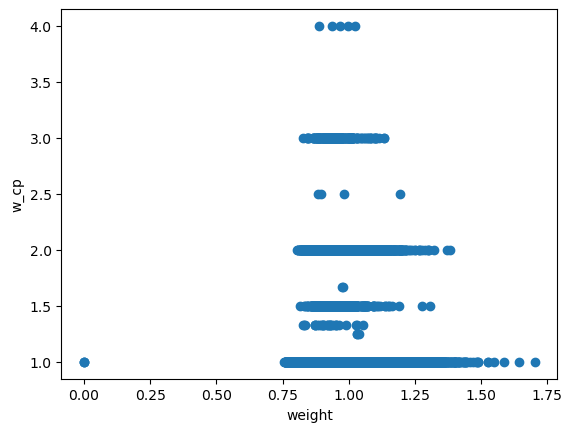

In [24]:
# plt.scatter(quasar_nocp['w'], quasar['w'])
# plt.show()
plt.scatter(quasar_nocp['w'], quasar['w']/quasar_nocp['w'])
plt.xlabel('weight')
plt.ylabel('w_cp')
plt.show()

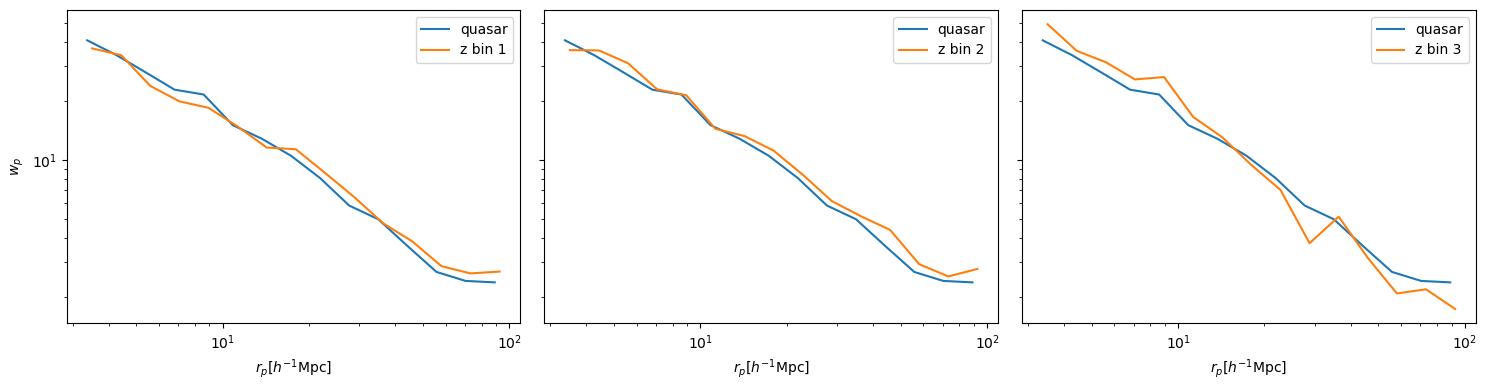

In [29]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 4))
for i in range(3):
    axes[i].plot(r_p, w, label='quasar')
    axes[i].plot(r_p*1.04, wzbin[i], label=f'z bin {i+1}')
    axes[i].set_xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
    axes[i].legend()
    axes[i].loglog()
axes[0].set_ylabel('$w_p$')
plt.tight_layout()

Jackknife

In [7]:
import healpy as hp

In [8]:
Nside_jack = 10

In [10]:
c = coo.SkyCoord(ra=quasar['ra']*u.degree, dec=quasar['dec']*u.degree)

l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
npix = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)
c = coo.SkyCoord(ra=random['ra']*u.degree, dec=random['dec']*u.degree)

l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
npix_r = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

pix = np.unique(npix)

In [9]:
with open('label.bin', 'rb') as f:
    npix = np.load(f)
    npix_r = np.load(f)
pix = np.unique(npix)

In [10]:
def resample(p, sender):
    sub_sample = npix != p
    sub_sample_r = npix_r != p

    quasar_sub = quasar[sub_sample]
    random_sub = random[sub_sample_r]

    dd = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                   RA1=quasar_sub['ra'], DEC1=quasar_sub['dec'], CZ1=dis_cov_q[sub_sample], weights1=quasar_sub['w'], is_comoving_dist=True, weight_type='pair_product')
    rr = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                    RA1=random_sub['ra'], DEC1=random_sub['dec'], CZ1=dis_cov_r[sub_sample_r], weights1=random_sub['w'], is_comoving_dist=True, weight_type='pair_product')
    dr = DDrppi_mocks(
        autocorr=False, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin, 
        RA1=quasar_sub['ra'], DEC1=quasar_sub['dec'], CZ1=dis_cov_q[sub_sample], weights1=quasar_sub['w'], 
        RA2=random_sub['ra'], DEC2=random_sub['dec'], CZ2=dis_cov_r[sub_sample_r], weights2=random_sub['w'], 
        is_comoving_dist=True, weight_type='pair_product')

    Nd = len(quasar_sub)
    Nr = len(random_sub)
    sender.send(1)
    return convert_rp_pi_counts_to_wp(Nd, Nd, Nr, Nr, dd, dr, dr, rr, pimax=pimax, nrpbins=Nbins)


In [11]:
def progress_bar(Ntotal, receiver, rate=10):
    # rate is the update rate of the progress bar.
    rate = max(1, int(rate))
    with tqdm(total=int(Ntotal/rate)) as pbar:
        count = 0
        while True:
            if receiver.recv():
                count += 1
                if count % rate == 0:
                    pbar.update(1)
            else:
                break
        pbar.close()

In [12]:
from itertools import repeat

In [13]:
sender, recv = mp.Pipe()

pool = mp.Pool(5)

bar = mp.Process(target=progress_bar, args=(len(pix), recv, 1))
bar.start()
w_arr = np.vstack(list(pool.starmap(resample, zip(pix, repeat(sender)))))
sender.send(0)
bar.join()

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

result of $w(\theta)$

In [20]:
dd_theta = DDtheta_mocks(autocorr=1, nthreads=50, binfile=theta_bins_deg,
                         RA1=quasar['ra'], DEC1=quasar['dec'], weights1=quasar['w'])
dr_theta = DDtheta_mocks(autocorr=0, nthreads=50, binfile=theta_bins_deg, 
                         RA1=quasar['ra'], DEC1=quasar['dec'], weights1=quasar['w'],
                         RA2=random['ra'], DEC2=random['dec'], weights2=random['w'])
rr_theta = DDtheta_mocks(autocorr=1, nthreads=50, binfile=theta_bins_deg, 
                         RA1=random['ra'], DEC1=random['dec'], weights1=random['w'])

In [21]:
w_theta = convert_3d_counts_to_cf(Nd, Nd, Nr, Nr, dd_theta, dr_theta, dr_theta, rr_theta)

<function matplotlib.pyplot.show(close=None, block=None)>

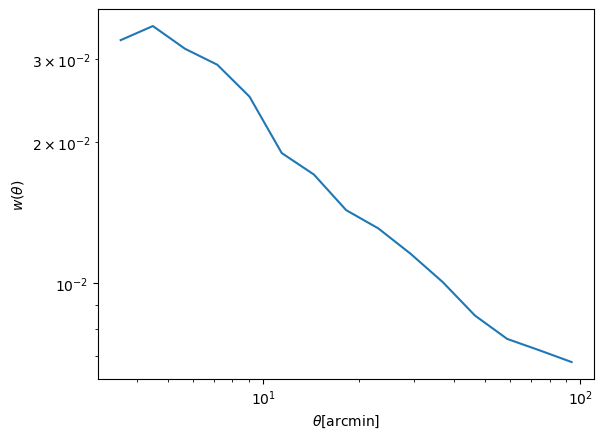

In [22]:
plt.plot((theta_bins_deg[1:]*theta_bins_deg[:-1])**0.5*60, w_theta)
plt.loglog()
plt.xlabel('$\\theta[\\mathrm{arcmin}]$')
plt.ylabel('$w(\\theta)$')
plt.show()